# FastSpecFit DESI Hiz

Simple notebook which shows how to work with the `FastSpecFit/desihiz` catalogs.

In [2]:
import os
import numpy as np
import fitsio
from glob import glob
import matplotlib.pyplot as plt
from astropy.table import Table

from fastspecfit.io import read_fastspecfit
from fastspecfit.util import TabulatedDESI
cosmo = TabulatedDESI()

from desiutil.log import get_logger
log = get_logger()

In [3]:
import seaborn as sns
sns.set(context='talk', style='ticks', font_scale=1.2)
%matplotlib inline

In [4]:
desi_root = os.getenv('DESI_ROOT')
projectdir = os.path.join(desi_root, 'users', 'ioannis', 'desihiz')

fspecdirs = {
    'odin': desi_root+'/users/raichoor/laelbg/odin/v20240129/desi-odin.fits[SPECINFO]',
    'clauds': desi_root+'/users/raichoor/laelbg/clauds/v20240129/desi-clauds.fits[SPECINFO]',
    'suprime': desi_root+'/users/raichoor/laelbg/suprime/v20231120/desi-suprime.fits[SPECINFO]',
    }

fphotodirs = {
    'odin': desi_root+'/users/raichoor/laelbg/odin/v20231120/desi-odin.fits[PHOTINFO]',
    'clauds': desi_root+'/users/raichoor/laelbg/clauds/v20231120/desi-clauds.fits[PHOTV2INFO]',
    'suprime': desi_root+'/users/raichoor/laelbg/suprime/v20231120/desi-suprime.fits[PHOTV2INFO]',
    }

In [5]:
def parse_fphotodir(fphotodir):
    # parse the extension name, if any
    fphotoext = None
    photodir = os.path.dirname(fphotodir)
    photobase = os.path.basename(fphotodir)
    if '[' in photobase and ']' in photobase:
        try:
            fphotoext = photobase[photobase.find('[')+1:photobase.find(']')]
            fphotodir = os.path.join(photodir, photobase[:photobase.find('[')])
        except:
            pass
    return fphotodir, fphotoext

In [36]:
def read_desihiz(selection='odin', targetids=None, vi_quality_cut=3., vi_redshifts=False):
    """Read Anand's desihiz catalogs.
    
    vi_quality_cut is only used if vi_redshifts=True
    
    """
    fspecdir = fspecdirs[selection]
    fphotodir = fphotodirs[selection]

    fspecdir, fspecext = parse_fphotodir(fspecdir)
    fphotobasedir, fphotoext = parse_fphotodir(fphotodir)

    fphoto = Table(fitsio.read(fphotobasedir, ext=fphotoext))
    log.info(f'Read {len(fphoto):,d} objects from {fphotobasedir}')

    fspec = Table(fitsio.read(fspecdir, ext=fspecext))
    log.info(f'Read {len(fspec):,d} objects from {fspecdir}')
    assert(np.all(fspec['TARGETID'] == fphoto['TARGETID']))

    if targetids:
        I = np.where(np.isin(fspec['TARGETID'], np.array(','.split(targetids))))[0]
        log.info(f'Trimming to {len(I):,d} specified TARGETIDs.')
        fphoto = fphoto[I]
        fspec = fspec[I]

    if vi_redshifts:
        #I = np.where(np.isfinite(fspec['VI_Z']) * (fspec['VI_QUALITY'] >= vi_quality_cut))[0]
        I = np.where(np.isfinite(fspec['VI_Z']) * (fspec['VI_Z'] > 1e-3) * (fspec['VI_QUALITY'] >= vi_quality_cut))[0]
        log.info(f'Trimming to {len(I):,d} objects with VI_Z>0.001 and VI_QUALITY>={vi_quality_cut}')
        fphoto = fphoto[I]
        fspec = fspec[I]

    return fphoto, fspec

In [37]:
selection = 'odin'
fphoto, fspec = read_desihiz(selection=selection, vi_redshifts=True, vi_quality_cut=3.)
fspec['TARGETID', 'VI', 'VI_Z', 'VI_SPECTYPE', 'VI_COMMENTS', 'COADDFN']
#fspec.columns

INFO:4102741067.py:14:read_desihiz: Read 11,580 objects from /global/cfs/cdirs/desi/users/raichoor/laelbg/odin/v20231120/desi-odin.fits
INFO:4102741067.py:17:read_desihiz: Read 11,580 objects from /global/cfs/cdirs/desi/users/raichoor/laelbg/odin/v20240129/desi-odin.fits
INFO:4102741067.py:29:read_desihiz: Trimming to 7,471 objects with VI_Z>0.001 and VI_QUALITY>=3.0


TARGETID,VI,VI_Z,VI_SPECTYPE,VI_COMMENTS,COADDFN
int64,bool,float32,str10,str450,str102
39089837390696448,True,3.123,GALAXY,LAE; single Lya line ; LAE,/global/cfs/cdirs/desi/users/raichoor/laelbg/iron/healpix/tileid82636-thru20220324-v2/coadd-27239.fits
39089837390695089,True,3.125425,GALAXY,LAE; single strong Lya line ; LAE,/global/cfs/cdirs/desi/users/raichoor/laelbg/iron/healpix/tileid82636-thru20220324-v2/coadd-27239.fits
39089837390695898,True,3.119,GALAXY,LAE; single strong Lya line ; LAE,/global/cfs/cdirs/desi/users/raichoor/laelbg/iron/healpix/tileid82636-thru20220324-v2/coadd-27239.fits
39089837390696440,True,2.0819,QSO,QSO; Lya CIV HeII CIII] MgII lines,/global/cfs/cdirs/desi/users/raichoor/laelbg/iron/healpix/tileid82636-thru20220324-v2/coadd-27239.fits
39089837390696436,True,3.13685,GALAXY,LAE; single strong Lya line,/global/cfs/cdirs/desi/users/raichoor/laelbg/iron/healpix/tileid82636-thru20220324-v2/coadd-27239.fits
39089837390696427,True,3.1239,GALAXY,no significant feature,/global/cfs/cdirs/desi/users/raichoor/laelbg/iron/healpix/tileid82636-thru20220324-v2/coadd-27239.fits
39089837390696431,True,3.1329,GALAXY,marginal detection at 5026A,/global/cfs/cdirs/desi/users/raichoor/laelbg/iron/healpix/tileid82636-thru20220324-v2/coadd-27239.fits
39089837390696441,True,3.1525,GALAXY,LAE; narrow line Lya ; LAE; narrow line Lya ; LAE; narrow Lya,/global/cfs/cdirs/desi/users/raichoor/laelbg/iron/healpix/tileid82636-thru20220324-v2/coadd-27239.fits
39089837390696435,True,3.152,GALAXY,no significant feature,/global/cfs/cdirs/desi/users/raichoor/laelbg/iron/healpix/tileid82636-thru20220324-v2/coadd-27239.fits


In [38]:
fast, meta, _, _ = read_fastspecfit(f'/global/cfs/cdirs/desi/users/ioannis/desihiz/{selection}/fastspec-vi-{selection}.fits')
#meta

INFO:io.py:1848:read_fastspecfit: Read 7,471 object(s) from /global/cfs/cdirs/desi/users/ioannis/desihiz/odin/fastspec-vi-odin.fits


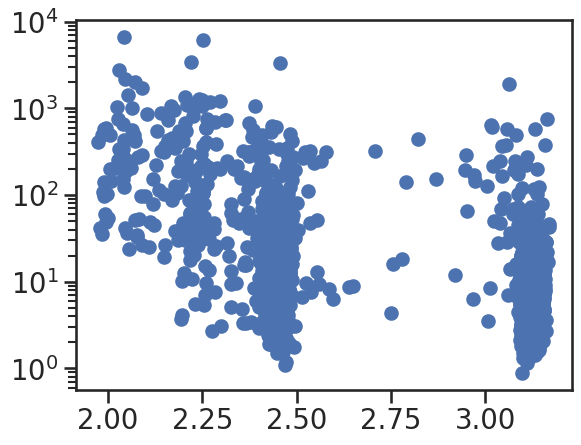

In [40]:
I = fast['LYALPHA_FLUX'] * np.sqrt(fast['LYALPHA_FLUX_IVAR']) > 2.
plt.scatter(fast['Z'][I], fast['LYALPHA_FLUX'][I])
plt.yscale('log')

In [ ]:
def read_data():
    mergefile = os.path.join(fastdir, 'fastspec-vi-tertiary26.fits')
    fast, meta, _, _ = read_fastspecfit(mergefile)

    vifile = os.path.join(fastdir, 'VI_dey_Subaru.fits.gz')
    vi = Table(fitsio.read(vifile))
    #iqso = ['qso' in comment.lower() or 'agn' in comment.lower() for comment in vi['VI_COMMENT']]
    #I = np.logical_not(iqso) * (vi['VI_QUALITY'] >=3) * (vi['VI_Z'] > 2.4) * (vi['VI_Z'] < 3.5)
    #vi = vi[I]
    vi.rename_column('VI_TARGETID', 'TARGETID')
    
    # trim out the LBGs
    #ilae = np.where(['lae' in comment.lower() for comment in vi['VI_COMMENT']])[0]
    #vi = vi[ilae]
    
    I = np.hstack([np.where(vi['TARGETID'] == tid)[0] for tid in fast['TARGETID']])
    vi = vi[I]
    #I = np.hstack([np.where(fast['TARGETID'] == tid)[0] for tid in vi['TARGETID']])
    #fast = fast[I]
    #meta = meta[I]
    
    fast['LYALPHA_LUM'] = fast['LYALPHA_FLUX'] * 1e-17 * 4 * np.pi * (cosmo.luminosity_distance(fast['Z']) * 3.0856776e+24)**2
    
    return vi, meta, fast

vi, meta, fast = read_data()
vi

In [ ]:
print(set(meta['HEALPIX']))
meta[meta['HEALPIX'] == 27245]['TARGETID'].data

In [ ]:
meta[np.isin(meta['TARGETID'], [39089837499746048, 39089837499745286])]['TARGETID', 'Z']

In [ ]:
meta['Z'].min()

In [ ]:
plt.scatter(meta['RA'], meta['DEC'], s=1)

In [ ]:
_ = plt.hist(meta['Z'], bins=100)

In [ ]:
_ = plt.hist(fast['LYALPHA_FLUX'], bins=100, range=(-10, 10))
#plt.xlim(-100, 1000)

In [ ]:
I = ['LBG' in comment for comment in vi['VI_COMMENT']]
vi[I]

In [ ]:
I = fast['LYALPHA_LUM'] > 0
_ = plt.hist(np.log10(fast['LYALPHA_LUM'][I]), bins=100)

In [ ]:
#vi[fast['LYALPHA_FLUX'] < 0]['TARGETID', 'VI_COMMENT']

In [ ]:
fast[fast['LYALPHA_FLUX'] == 0.]['HEALPIX', 'TARGETID', 'LYALPHA_FLUX', 'LYALPHA_EW']

In [ ]:
plt.scatter(fast['Z'], fast['LYALPHA_LUM'])
plt.yscale('log')
#plt.ylim(-100, 500)

In [ ]:
minmax = np.array([3600, 9800, 0.8]) 
minmax / (1 + meta['Z'].min()), minmax / (1+meta['Z'].max())
minmax / (1 + 2.4), minmax / (1+3.5)

In [ ]:
minwave, maxwave, dwave = 920., 2500., 0.05
gridwave = np.arange(minwave, maxwave+dwave, dwave)
gridwave

Stack everything

In [ ]:
allspec = []
for healpix in sorted(set(meta['HEALPIX'])):
    mm = meta[meta['HEALPIX'] == healpix]    
    specfile = os.path.join(datadir, f'coadd-{healpix}.fits')
    spec = read_spectra(specfile).select(targets=mm['TARGETID'])
    allspec.append(spec)
allspec = desispec.spectra.stack(allspec)

In [ ]:
srt = np.hstack([np.where(meta['TARGETID'] == tid)[0] for tid in allspec.fibermap['TARGETID']])
fast = fast[srt]
meta = meta[srt]
assert(np.all(meta['TARGETID'] == allspec.fibermap['TARGETID']))

In [ ]:
(flux, ivar), wave = stack_spectra(allspec, redshift=meta['Z'], norm_method='flux-window', #"mean", "median", "flux-window"
                                   norm_flux_window=[1500, 1550], output_wave_grid=gridwave,
                                   resample_method='linear', # "linear", "sn-cons", "flux-cons"
                                   stack_method='ivar-weighted-mean', # median , mean
                                   n_workers=24, bootstrap=True)

In [ ]:
I = (wave > 1100) * (wave < 1350)
plt.plot(wave[I], flux[I])

In [ ]:
plt.plot(wave, flux)